In [50]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
%matplotlib inline
import seaborn as sns
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

## Import Pengolahan Dataset

In [51]:
dila = pd.read_csv('Wholesale customers data.csv')
dila.style.background_gradient(cmap =sns.cubehelix_palette(as_cmap=True))

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
5,2,3,9413,8259,5126,666,1795,1451
6,2,3,12126,3199,6975,480,3140,545
7,2,3,7579,4956,9426,1669,3321,2566
8,1,3,5963,3648,6192,425,1716,750
9,2,3,6006,11093,18881,1159,7425,2098


### Buat fitur untuk ukuran total pelanggan. 

In [3]:
dila['Total'] = dila['Fresh'] + dila['Milk'] + dila['Grocery'] + dila['Frozen'] + dila['Detergents_Paper'] + dila['Delicassen']
print (dila.head())

   Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  \
0        2       3  12669  9656     7561     214              2674   
1        2       3   7057  9810     9568    1762              3293   
2        2       3   6353  8808     7684    2405              3516   
3        1       3  13265  1196     4221    6404               507   
4        2       3  22615  5410     7198    3915              1777   

   Delicassen  Total  
0        1338  34112  
1        1776  33266  
2        7844  36610  
3        1788  27381  
4        5185  46100  


Tambahkan fungsi untuk mengonversi dan menggabungkan variabel dummy ke model.

In [4]:
def get_dummies(source_dila, dest_dila, col):
    dummies = pd.get_dummies(source_dila[col], prefix=col)

    print ('Quantities for %s column' % col) 
    for col in dummies:
        print ('%s: %d' % (col, np.sum(dummies[col])))
    print

    dest_dila = dest_dila.join(dummies)
    return dest_dila

Memproses variabel dummy untuk fitur 'Channel' dan 'Region', dan menghilangkan fitur kategoris asli, dan menghilangkan salah satu variabel dummy untuk pengkodean 'leave one out'.

In [5]:
dila = get_dummies(dila, dila, 'Channel')
dila.drop(['Channel', 'Channel_2'], axis=1, inplace=True)
dila = get_dummies(dila, dila, 'Region')
dila.drop(['Region', 'Region_3'], axis=1, inplace=True)
dila.rename(index=str, columns={'Channel_1': 'Channel_Horeca', 'Region_1': 'Region_Lisbon', 'Region_2': 'Region_Oporto'},
                              inplace=True)
print (dila.head())

Quantities for Channel column
Channel_1: 298
Channel_2: 142
Quantities for Region column
Region_1: 77
Region_2: 47
Region_3: 316
   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen  Total  \
0  12669  9656     7561     214              2674        1338  34112   
1   7057  9810     9568    1762              3293        1776  33266   
2   6353  8808     7684    2405              3516        7844  36610   
3  13265  1196     4221    6404               507        1788  27381   
4  22615  5410     7198    3915              1777        5185  46100   

   Channel_Horeca  Region_Lisbon  Region_Oporto  
0               0              0              0  
1               0              0              0  
2               0              0              0  
3               1              0              0  
4               0              0              0  


Plot histogram ukuran pelanggan, menunjukkan sejumlah kecil pelanggan besar, banyak pelanggan kecil.

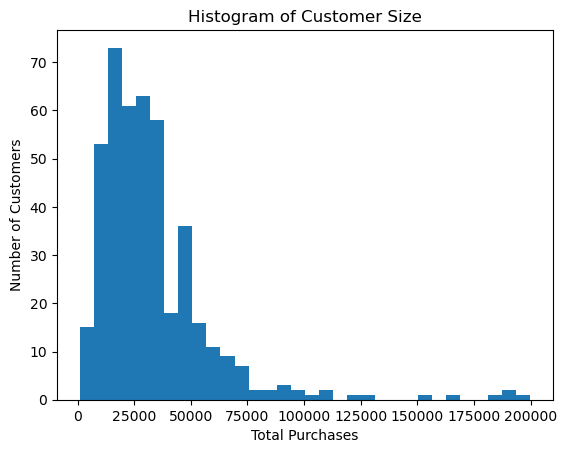

In [7]:
plt.hist(dila['Total'], bins=32)
plt.xlabel('Total Purchases')
plt.ylabel('Number of Customers')
plt.title('Histogram of Customer Size')
plt.show()
plt.close()

Skalakan data sehingga tidak ada kategori yang mendominasi karena skala numerik.

In [8]:
sc = StandardScaler()
sc.fit(dila)
X = sc.transform(dila)

Menyiapkan fungsi plot untuk keluaran K Means.

In [20]:
def plot_kmeans(pred, centroids, x_name, y_name, x_idx, y_idx, k):
    for i in range(0, k):
        plt.scatter(dila[x_name].loc[pred == i], dila[y_name].loc[pred == i], s=6,
                    c=colors[i], marker=markers[i], label='Cluster %d' % (i + 1))

    centroids = sc.inverse_transform(kmeans.cluster_centers_)
    plt.scatter(centroids[:, x_idx], centroids[:, y_idx],
                marker='x', s=180, linewidths=3,
                color='k', zorder=10)

    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.legend()
    plt.show()
    plt.close()

mencoba K-Means dengan k = 3 (karena ketika saya menggunakan R, 3 memberikan hasil yang menarik). Nilai 'k' akan ditetapkan dari grafik distorsi nanti.

In [22]:
k=3
kmeans = KMeans(n_clusters=k)
kmeans.fit(X)
pred = kmeans.predict(X)

for i in range(0, k):
    x = len(pred[pred == i])
    print ('Cluster %d has %d members' % ((i + 1), x))

Cluster 1 has 131 members
Cluster 2 has 13 members
Cluster 3 has 296 members


menggunakan transformasi invers pada centroid. Diperlukan karena centroid dihitung berdasarkan data berskala dan saya ingin centroid diplot dengan benar dengan data asli.

In [23]:
centroids = sc.inverse_transform(kmeans.cluster_centers_)

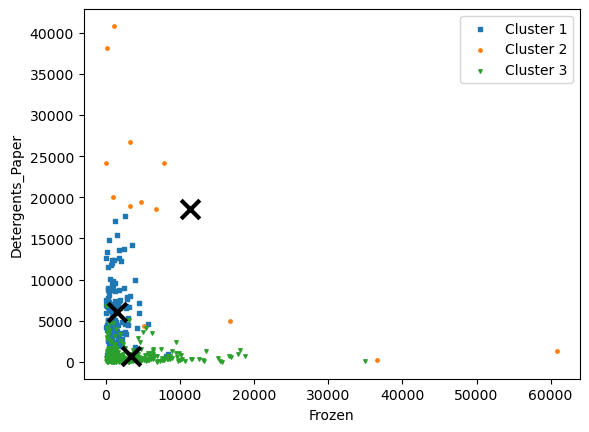

In [24]:
plot_kmeans(pred, centroids, 'Frozen', 'Detergents_Paper', 3, 4, k)

Penjelasan: Kehadiran beberapa pelanggan besar membuat plot dengan lebih banyak cluster sulit untuk diinterpretasikan karena massa pelanggan yang lebih kecil didorong ke sudut kanan bawah grafik di atas. Meskipun perilaku pelanggan besar merupakan hal yang menarik, terutama dalam lingkungan bisnis, di sini saya akan fokus pada pelanggan kecil. Tampilan histogram di atas menjadikan tingkat penjualan sebagai titik terobosan yang wajar. Selain itu, ketika saya mencobanya di R, algoritma K Means cenderung menghasilkan dua cluster pelanggan besar dan satu untuk sejumlah besar pelanggan kecil. Plot di atas dipilih karena mewakili suatu pola dalam data - yaitu ada pelanggan yang membeli satu jenis produk dari klien grosir saya tetapi tidak membeli jenis produk lainnya.

Menyiapkan struktur data untuk pelanggan kecil. Disini kita perlu mengubah skala data karena hilangnya pelanggan yang lebih besar.

In [25]:
dila = dila.loc[dila['Total'] <= 75000]

sc = StandardScaler()
sc.fit(dila)
X = sc.transform(dila)

Membuat grafik distorsi atau siku untuk membantu memilih nilai k yang optimal.

C:\Users\Dila\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


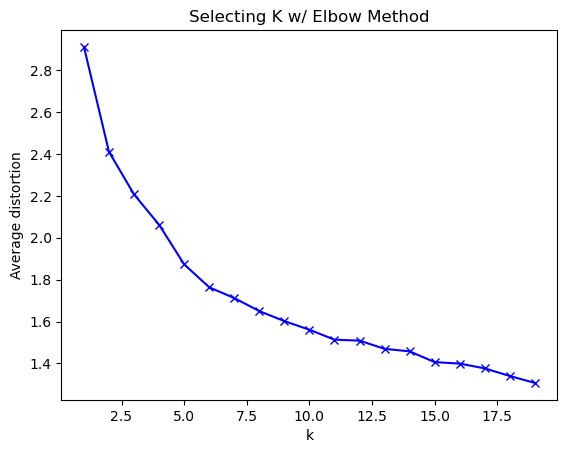

In [26]:
K = range(1, 20)
mean_distortions = []
for k in K:
    np.random.seed(555)
    kmeans = KMeans(n_clusters=k, init='k-means++')
    kmeans.fit(X)
    mean_distortions.append(sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis = 1))/ X.shape[0])

plt.plot(K, mean_distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting K w/ Elbow Method')
plt.show()
plt.close()

Plot distorsi memiliki titik siku-siku yang sulit diinterpretasikan, tetapi k = 6 sepertinya dapat menghasilkan kumpulan cluster dan plot yang menarik.

In [27]:
np.random.seed(555) 
k = 6
kmeans = KMeans(n_clusters=k)  
kmeans.fit(X)
pred = kmeans.predict(X)

for i in range(0, k):
    x = len(pred[pred == i])
    print ('Cluster %d has %d members' % ((i + 1), x))

Cluster 1 has 60 members
Cluster 2 has 153 members
Cluster 3 has 39 members
Cluster 4 has 53 members
Cluster 5 has 78 members
Cluster 6 has 37 members


Plot K  hasil dengan centroid.

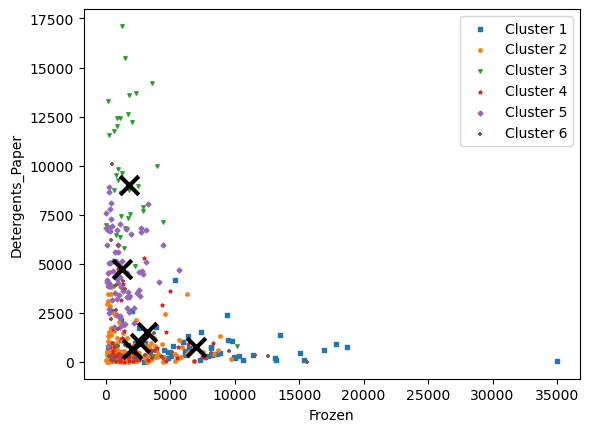

In [28]:
centroids = sc.inverse_transform(kmeans.cluster_centers_)
plot_kmeans(pred, centroids, 'Frozen', 'Detergents_Paper', 3, 4, k)

Pola yang terlihat pada kumpulan data lengkap juga muncul di antara kumpulan pelanggan dengan total penjualan kurang dari 75.000 euro. Misalnya, ada sejumlah pelanggan yang membeli Detergents dan Paper dari klien kami namun tidak membeli barang beku, hal sebaliknya juga terjadi. 

Mencetak data cluster.

In [36]:
def print_cluster_data(cluster_number):
    print ('\nData for cluster %d' % cluster_number)
    cluster = dila.loc[pred == cluster_number - 1, :]
    # print cluster1.head()
    num_in_cluster = float(len(cluster.index))
    num_horeca = float(np.sum(cluster['Channel_Horeca']))
    num_retail = float(num_in_cluster - num_horeca)
    print('Percent Horeca: %.2f, Percent Retail: %.2f' % (percent_horeca, percent_retail)) \
          (num_horeca / num_in_cluster * 100.0, num_retail / num_in_cluster * 100.0)

    num_lisbon = float(np.sum(cluster['Region_Lisbon']))
    num_oporto = float(np.sum(cluster['Region_Oporto']))
    num_other = num_in_cluster - num_lisbon - num_oporto
    print('Percent Lisbon: %.2f, Percent Oporto: %.2f, Percent Other: %.2f' % (percent_lisbon, percent_oporto, percent_other)) \
          ((num_lisbon / num_in_cluster * 100.0, num_oporto / num_in_cluster * 100.0, num_other / num_in_cluster * 100.0)

    avg_cust_size = np.sum(cluster['Total']) / num_in_cluster
    print ('Average Customer Size is: %.2f for %d Customers' % (avg_cust_size, num_in_cluster))

Print data untuk cluster 1, 3 dan 5.

In [48]:
def print_cluster_data(cluster_number):
    print('\nData for cluster %d' % cluster_number)
    cluster = dila.loc[pred == cluster_number - 1, :]
    num_in_cluster = float(len(cluster.index))
    
    num_horeca = float(np.sum(cluster['Channel_Horeca']))
    num_retail = float(num_in_cluster - num_horeca)
    
    percent_horeca = num_horeca / num_in_cluster * 100.0
    percent_retail = num_retail / num_in_cluster * 100.0
    
    print('Percent Horeca: %.2f, Percent Retail: %.2f' % (percent_horeca, percent_retail))

print_cluster_data(cluster_number=1)
print_cluster_data(cluster_number=3)
print_cluster_data(cluster_number=5)



Data for cluster 1
Percent Horeca: 93.33, Percent Retail: 6.67

Data for cluster 3
Percent Horeca: 7.69, Percent Retail: 92.31

Data for cluster 5
Percent Horeca: 3.85, Percent Retail: 96.15


penjelasan: kelompok 3 dan 5 didominasi oleh pelanggan ritel, dalam lingkungan bisnis sebenarnya kita mungkin ingin menyelidiki mengapa mereka membeli banyak deterjen dan kertas dari klien kita tetapi tidak banyak membeli barang beku. Cluster 1 mewakili pelanggan dari saluran distribusi “Horeca” (hotel, restoran, kafe). Pelanggan ini cenderung membeli barang beku namun tidak membeli deterjen dan kertas, mungkin karena mereka menjual makanan dan hanya menggunakan deterjen dan kertas sebagai perlengkapan perawatan. Clustering dapat membantu dalam analisis segmentasi pemasaran dengan mengidentifikasi jenis dan kelompok pelanggan.